In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os

import pdb
import pickle


# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

In [2]:
data_train = {}
data_val = {}
data_test={}
a = 0
b = 0
c = 0
max_len = 0
for j in range(1,4):
    for i in os.listdir('./final_dataset/train/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data_train['%s'%a] = pd.read_csv('./final_dataset/train/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')
            if len(data_train['%s'%a])/20>max_len:
                max_len=int(len(data_train['%s'%a])/20)
        
    for k in os.listdir('./final_dataset/validation/%s'%j):
        if k.endswith('.txt'):
            b = b+1
            data_val['%s'%b] = pd.read_csv('./final_dataset/validation/{}/{}'.format(j,k), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ') 
    
    for k in os.listdir('./final_dataset/test/%s' % j):
        if k.endswith('.txt'):
            c = c + 1
            data_test['%s' % c] = pd.read_csv('./final_dataset/test/{}/{}'.format(j, k), header=None,
                                              names=['frameNb', 'id', 'x', 'y', 'Vx', 'Vy'],
                                              delimiter=' ')

In [3]:
data_test_1 = {}
c = 0
j = 1
for i in os.listdir('./final_dataset/test/%s'%j):
    if i.endswith('.txt'):
        c = c+1
        data_test_1['%s'%c] = pd.read_csv('./final_dataset/test/{}/{}'.format(j,i), header = None, 
                                    names = ['frameNb','id', 'x','y','Vx','Vy'],
                                       delimiter=' ')

data_test_2 = {}
c = 0
j = 2
for i in os.listdir('./final_dataset/test/%s'%j):
    if i.endswith('.txt'):
        c = c+1
        data_test_2['%s'%c] = pd.read_csv('./final_dataset/test/{}/{}'.format(j,i), header = None, 
                                    names = ['frameNb','id', 'x','y','Vx','Vy'],
                                       delimiter=' ')

data_test_3 = {}
c = 0
j = 3
for i in os.listdir('./final_dataset/test/%s'%j):
    if i.endswith('.txt'):
        c = c+1
        data_test_3['%s'%c] = pd.read_csv('./final_dataset/test/{}/{}'.format(j,i), header = None, 
                                    names = ['frameNb','id', 'x','y','Vx','Vy'],
                                       delimiter=' ')

## TRAIN SET

In [5]:
a = 0
inputs_train = np.zeros([10,len(data_train),4*max_len])
gt_train = np.zeros([11,len(data_train),4])
in_train_coord = np.zeros([10,len(data_train),2])
gt_train_coord = np.zeros([11,len(data_train),2])

for i in data_train:
    len_d = np.int(len(data_train['%s'%i])/20)
    inputs_train[:,a,:4] = data_train['%s'%i].loc[0:9,'x':'Vy']
    for j in range(1,len_d):
        for m in range(10):
            frame = np.array(data_train['%s'%i].loc[m,'frameNb'])
            no_int = 0
            check = 0
            for k in range(20):
                if data_train['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_train[m,(a),(j-no_int)*4:(j+1-no_int)*4]=data_train['%s'%i].loc[j*20+k,'x':'Vy']
                    check+=1
            if check == 0:
                no_int+=1           

        
    gt_train[:,a,:] = np.array(data_train['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_train_coord[:,a,:] = np.array(data_train['%s'%i].loc[0:9,['x','y']])
    gt_train_coord[:,a,:] = np.array(data_train['%s'%i].loc[9:19,['x','y']])
    a +=1

while sum(sum(sum(inputs_train[:,:,-4:]!=0)))==0:
    inputs_train = inputs_train[:,:,:-4]

inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()
inputs_train = inputs_train.permute([1,0,2])
gt_train = gt_train.permute([1,0,2])
inputs_train.shape


torch.Size([5157, 10, 244])

In [17]:
pickle.dump( inputs_train.numpy(), open( "./import_dataset_3/train/inputs_train.pkl", "wb" ) )
pickle.dump( gt_train.numpy(), open( "./import_dataset_3/train/gt_train.pkl", "wb" ) )
pickle.dump( in_train_coord, open( "./import_dataset_3/train/in_train_coord.pkl", "wb" ) )
pickle.dump( gt_train_coord, open( "./import_dataset_3/train/gt_train_coord.pkl", "wb" ) )


## VALIDATION SET

In [18]:
a = 0
inputs_validation = np.zeros([10,len(data_val),inputs_train.shape[2]])
gt_validation = np.zeros([11,len(data_val),4])
in_validation_coord = np.zeros([10,len(data_val),2])
gt_validation_coord = np.zeros([11,len(data_val),2])

for i in data_val:
    len_d = np.int(len(data_val['%s'%i])/20)
    inputs_validation[:,a,:4] = data_val['%s'%i].loc[0:9,'x':'Vy']
    for j in range(1,len_d):    
        for m in range(10):
            frame = np.array(data_val['%s'%i].loc[m,'frameNb'])  
            no_int = 0
            check = 0            
            for k in range(20):
                if data_val['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_validation[m,a,(j-no_int)*4:(j+1-no_int)*4]=data_val['%s'%i].loc[j*20+k,'x':'Vy']
                    check+=1
            if check == 0:
                no_int+=1  
    gt_validation[:,a,:] = np.array(data_val['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_validation_coord[:,a,:] = np.array(data_val['%s'%i].loc[0:9,['x','y']])
    gt_validation_coord[:,a,:] = np.array(data_val['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()
inputs_validation = inputs_validation.permute([1,0,2])
gt_validation = gt_validation.permute([1,0,2])


In [19]:
pickle.dump( inputs_validation.numpy(), open( "./import_dataset_3/validation/inputs_validation.pkl", "wb" ) )
pickle.dump( gt_validation.numpy(), open( "./import_dataset_3/validation/gt_validation.pkl", "wb" ) )
pickle.dump( in_validation_coord, open( "./import_dataset_3/validation/in_validation_coord.pkl", "wb" ) )
pickle.dump( gt_validation_coord, open( "./import_dataset_3/validation/gt_validation_coord.pkl", "wb" ) )


## TEST SET

In [20]:
a = 0
inputs_test_1 = np.zeros([10,len(data_test_1),inputs_train.shape[2]])
gt_test_1 = np.zeros([11,len(data_test_1),4])
in_test_coord_1 = np.zeros([10,len(data_test_1),2])
gt_test_coord_1 = np.zeros([11,len(data_test_1),2])

for i in data_test_1:
    len_d = np.int(len(data_test_1['%s'%i])/20)
    inputs_test_1[:,a,:4] = data_test_1['%s'%i].loc[0:9,'x':'Vy']
    for j in range(1,len_d):
        for m in range(10):
            frame = np.array(data_test_1['%s'%i].loc[m,'frameNb'])
            no_int=0
            check = 0
            for k in range(20):
                if data_test_1['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_test_1[m,a,(j-no_int)*4:(j+1-no_int)*4]=data_test_1['%s'%i].loc[j*20+k,'x':'Vy']
                    check+=1
            if check == 0:
                no_int+=1 
                
    gt_test_1[:,a,:] = np.array(data_test_1['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_test_coord_1[:,a,:] = np.array(data_test_1['%s'%i].loc[0:9,['x','y']])
    gt_test_coord_1[:,a,:] = np.array(data_test_1['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_test_1 = torch.from_numpy(inputs_test_1).float()
gt_test_1 = torch.from_numpy(gt_test_1).float()

In [21]:
pickle.dump( inputs_test_1.numpy(), open( "./import_dataset_3/test/inputs_test_1.pkl", "wb" ) )
pickle.dump( gt_test_1.numpy(), open( "./import_dataset_3/test/gt_test_1.pkl", "wb" ) )
pickle.dump( in_test_coord_1, open( "./import_dataset_3/test/in_test_coord_1.pkl", "wb" ) )
pickle.dump( gt_test_coord_1, open( "./import_dataset_3/test/gt_test_coord_1.pkl", "wb" ) )


In [22]:
a = 0
inputs_test_2 = np.zeros([10,len(data_test_2),inputs_train.shape[2]])
gt_test_2 = np.zeros([11,len(data_test_2),4])
in_test_coord_2 = np.zeros([10,len(data_test_2),2])
gt_test_coord_2 = np.zeros([11,len(data_test_2),2])

for i in data_test_2:
    len_d = np.int(len(data_test_2['%s'%i])/20)
    inputs_test_2[:,a,:4] = data_test_2['%s'%i].loc[0:9,'x':'Vy']
    for j in range(1,len_d):    
        for m in range(10):
            frame = np.array(data_test_2['%s'%i].loc[m,'frameNb'])  
            no_int=0
            check = 0
            for k in range(20):
                if data_test_2['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_test_2[m,a,(j-no_int)*4:(j+1-no_int)*4]=data_test_2['%s'%i].loc[j*20+k,'x':'Vy']
                    check+=1
            if check ==0:
                no_int+=1
                    
    gt_test_2[:,a,:] = np.array(data_test_2['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_test_coord_2[:,a,:] = np.array(data_test_2['%s'%i].loc[0:9,['x','y']])
    gt_test_coord_2[:,a,:] = np.array(data_test_2['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_test_2 = torch.from_numpy(inputs_test_2).float()
gt_test_2 = torch.from_numpy(gt_test_2).float()

In [23]:
pickle.dump( inputs_test_2.numpy(), open( "./import_dataset_3/test/inputs_test_2.pkl", "wb" ) )
pickle.dump( gt_test_2.numpy(), open( "./import_dataset_3/test/gt_test_2.pkl", "wb" ) )
pickle.dump( in_test_coord_2, open( "./import_dataset_3/test/in_test_coord_2.pkl", "wb" ) )
pickle.dump( gt_test_coord_2, open( "./import_dataset_3/test/gt_test_coord_2.pkl", "wb" ) )


In [24]:
a = 0
inputs_test_3 = np.zeros([10,len(data_test_3),inputs_train.shape[2]])
gt_test_3 = np.zeros([11,len(data_test_3),4])
in_test_coord_3 = np.zeros([10,len(data_test_3),2])
gt_test_coord_3 = np.zeros([11,len(data_test_3),2])


for i in data_test_3:
    len_d = np.int(len(data_test_3['%s'%i])/20)
    inputs_test_3[:,a,:4] = data_test_3['%s'%i].loc[0:9,'x':'Vy']
    for j in range(1,len_d):    
        for m in range(10):
            frame = np.array(data_test_3['%s'%i].loc[m,'frameNb'])  
            no_int = 0
            check = 0
            for k in range(20):
                if data_test_3['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs_test_3[m,a,(j-no_int)*4:(j+1-no_int)*4]=data_test_3['%s'%i].loc[j*20+k,'x':'Vy']
                    check+=1
            if check == 0:
                no_int+=1
                
    
    gt_test_3[:,a,:] = np.array(data_test_3['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_test_coord_3[:,a,:] = np.array(data_test_3['%s'%i].loc[0:9,['x','y']])
    gt_test_coord_3[:,a,:] = np.array(data_test_3['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()
no_int

1

In [25]:
pickle.dump( inputs_test_3.numpy(), open( "./import_dataset_3/test/inputs_test_3.pkl", "wb" ) )
pickle.dump( gt_test_3.numpy(), open( "./import_dataset_3/test/gt_test_3.pkl", "wb" ) )
pickle.dump( in_test_coord_3, open( "./import_dataset_3/test/in_test_coord_3.pkl", "wb" ) )
pickle.dump( gt_test_coord_3, open( "./import_dataset_3/test/gt_test_coord_3.pkl", "wb" ) )


# TEST SET 2 for gif

In [ ]:
a = 0
inputs_test = np.zeros([20, len(data_test), 160])

for i in data_test:
    len_d = np.int(len(data_test['%s' % i]) / 20)
    inputs_test[:, a, :2] = data_test['%s' % i].loc[0:19, 'x':'y']
    for j in range(1, len_d):
        for m in range(20):
            frame = np.array(data_test['%s' % i].loc[m, 'frameNb'])
            no_int = 0
            check = 0
            for k in range(20):
                if data_test['%s' % i].loc[j*20+k, 'frameNb'] == frame:
                    #print(k)
                    inputs_test[m,a,(j-no_int)*2:(j+1-no_int)*2] = data_test['%s' % i].loc[j*20+k,'x':'y']
                    check += 1
            if check == 0:
                no_int += 1
    a += 1
    
    
while sum(sum(sum(inputs_test[:,:,-2:]!=0)))==0:
    inputs_test = inputs_test[:,:,:-2]
    


In [ ]:
pickle.dump( inputs_test, open( "./import_dataset_3/inputs_dyn_plot.pkl", "wb" ) )

(-5.309107065200806, 4.433758020401001, -6.928119444847107, 5.399133944511414)

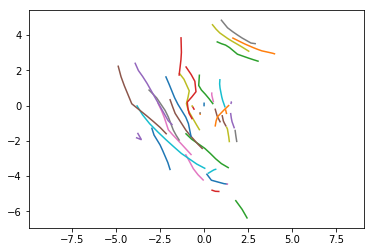

In [28]:
inputs_train=inputs_train.numpy()
for i in range(41):
    inp = inputs_train[700,:,4*i:4*i+2]
    if sum(sum(inp))==0:
        continue
    if i>0:
        while sum(inp[0,:])==0:
            inp = inp[1:,:]
            if len(inp)>0:
                continue
        while sum(inp[-1,:])==0:
            inp = inp[:-1,:]
            if len(inp)>0:
                continue
    if len(inp)>0:
        plt.plot(inp[:,0],inp[:,1])
#plt.plot(inputs_train[:,300,0],inputs_train[:,299,0],c='k')
plt.axis('equal')

In [ ]:
for i in range(0,6):
    plt.plot(data_test['701'].loc[20*i:((i+1)*20-1),'x'],data_test['701'].loc[20*i:((i+1)*20-1),'y'])
plt.axis('equal')

# END OF SAVING

In [ ]:
len(data_test),inputs_test.shape

In [16]:
np.array(data_train['300'].loc[20:39,'x':'y']),inputs_train[299,:,4:6]

(array([[ 3.00514886e+00,  1.84381814e+00],
        [ 2.65188971e+00,  1.97762761e+00],
        [ 2.29863056e+00,  2.11143708e+00],
        [ 1.94596278e+00,  2.24605295e+00],
        [ 1.59469276e+00,  2.38088387e+00],
        [ 1.24342274e+00,  2.51571479e+00],
        [ 8.55972020e-01,  2.64855657e+00],
        [ 4.29545060e-01,  2.77897914e+00],
        [ 3.70946000e-03,  2.91020811e+00],
        [-3.67828200e-01,  3.10702469e+00],
        [-6.57220070e-01,  3.40233020e+00],
        [-9.46611940e-01,  3.69763571e+00],
        [-1.23229435e+00,  3.98278051e+00],
        [-1.50614949e+00,  4.22825019e+00],
        [-1.78140240e+00,  4.47350483e+00],
        [-2.02563559e+00,  4.71709290e+00],
        [-2.24024684e+00,  4.95879936e+00],
        [-2.45405168e+00,  5.19991445e+00],
        [-2.68065149e+00,  5.44049195e+00],
        [-2.91203596e+00,  5.67961791e+00]]), tensor([[-2.4541,  5.1999],
         [-2.6807,  5.4405],
         [-2.9120,  5.6796],
         [ 0.0000,  0.0000],
   

In [15]:
np.array(data_train['300'].loc[0:19,'frameNb']),np.array(data_train['300'].loc[20:39,'frameNb'])



(array([3400, 3410, 3420, 3430, 3440, 3450, 3460, 3470, 3480, 3490, 3500,
        3510, 3520, 3530, 3540, 3550, 3560, 3570, 3580, 3590]),
 array([3230, 3240, 3250, 3260, 3270, 3280, 3290, 3300, 3310, 3320, 3330,
        3340, 3350, 3360, 3370, 3380, 3390, 3400, 3410, 3420]))

In [ ]:
for j in range(1, len_d):
    for m in range(20):
        frame = np.array(data_test['300'].loc[m, 'frameNb'])
        no_int = 0
        check = 0
        for k in range(20):
            if data_test['300'].loc[j*20+k, 'frameNb'] == frame:
                print(k)
                print(m)
                print(frame)
                #inputs_test[m,a,(j-no_int)*2:(j+1-no_int)*2] = data_test['300'].loc[j*20+k,'x':'y']
                #check += 1
        if check == 0:
            no_int += 1

In [ ]:
from torch import optim

lr = 0.01
lstm = LSTM(4*max_len,4,num_layers=2,hidden_size=128)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

In [ ]:
traindataset = utils.TensorDataset(inputs_train, gt_train[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

epochs = 50
steps = 0
print_every = 323
running_loss = 0 #### DOD

loss_train = []
loss_val = []
for e in range(epochs):
    start = time.time()
    total_train_loss=0
    steps_bis = 0
    if (e+1)%10==0:
        lr /= 5
        optimizer = optim.SGD(lstm.parameters(), lr=lr)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        steps_bis+=1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        out = lstm.forward(in_train)
        out_bis = out[:,:,0:2].clone()
        #print(out_bis.shape)    
        for i in range(10):
            if i == 0:
                out_bis[i, :, 0:2] = in_train[-1, :, 0:2] + out[i, :, 2:]*0.4
            else:
                out_bis[i, :, 0:2] = out[i - 1, :, 0:2] + out[i, :, 2:]*0.4
        #pdb.set_trace()
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
        loss4 = 5*criterion(out[0,:,2:], targets[0,:,2:])
                                #+ 10*criterion(out_bis[-1,:,:], targets[-1,:,0:2]) 
                                #+ 10*criterion(out_bis[0,:,:], targets[0,:,0:2]))
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward(retain_graph=True)
        loss4.backward()
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3+loss4).data[0]
        total_train_loss += (loss1+loss2+loss3+loss4).data[0]
    
        if steps % print_every == 0:
                stop = time.time()
                val_loss=0
                for ii, (valcoord, valgt) in enumerate(valloader):
                    inputs = Variable(valcoord, volatile=True)
                    predicted = lstm.predict(inputs)
                    val_loss+= criterion(predicted,valgt).data[0]
                    
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation loss: {:.4f}..".format(val_loss/ii),
                  "Training loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
                loss_val.append(val_loss/ii)
                running_loss = 0
                start = time.time()
    loss_train.append(total_train_loss/steps_bis)

In [ ]:
output_test = lstm.predict(inputs_test)
output_test = output_test.data.numpy()

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

In [ ]:
output_coord=np.zeros([11,len(data_test),2])
for j in range(11):
    for i in range(len(data_test)):
        if j==0:
            output_coord[j,i,0:2] = in_test_coord[9,i,0:2]
        else:
            output_coord[j,i,0:2] = output_coord[j-1,i,0:2]+output_test[j-1,i,2:]*0.4
        

In [ ]:
dist = np.zeros(len(data_test))
for i in range(len(data_test)):
    dist[i] = np.sqrt(sum((gt_test_coord[10,i,:]-output_coord[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

In [ ]:
avr = np.zeros((len(data_test),11))
for i in range(len(data_test)):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord[j,i,:]-output_coord[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

In [ ]:
for i in range(20):
    plt.figure(figsize=(12, 7))

    plt.plot(in_test_coord[:,(i*20)+800,0],in_test_coord[:,i*20+800,1],c='b')
    plt.plot(gt_test_coord[:,i*20+800,0],gt_test_coord[:,i*20+800,1],c='k')
    plt.plot(output_coord[:,i*20+800,0],output_coord[:,i*20+800,1],c='r')
    plt.axis('equal')

In [ ]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()

In [ ]:
epoch = np.arange(1,epochs+1,0.5)
epoch

In [ ]:
epoch

In [ ]:
inputs_train.shape[2]

In [ ]:
inputs_test[input_test]